# Implied Volatility Prediction

## 1. Import Libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d, CubicSpline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Data

In [10]:
# Load data
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

# Display shapes
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
print("Sample submission shape:", sample_sub.shape)

# Display first few rows of training data
train.head()

Training data shape: (178340, 97)
Test data shape: (12065, 96)
Sample submission shape: (12065, 53)


,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063


## 4. Prepare IV Columns

In [11]:
# Get all IV columns from TEST data
iv_columns = [col for col in test.columns if col.startswith(('call_iv_', 'put_iv_'))]

# Create strike dictionary from TEST columns
strike_dict = {}
for col in iv_columns:
    strike = col.split('_')[-1]
    if strike not in strike_dict:
        strike_dict[strike] = {'call': None, 'put': None}
    
    if col.startswith('call_iv_'):
        strike_dict[strike]['call'] = col
    else:
        strike_dict[strike]['put'] = col

print(f"Total IV columns: {len(iv_columns)}")
print(f"Unique strikes: {len(strike_dict)}")
print("Sample strike dictionary entries:", dict(list(strike_dict.items())[:3]))

Total IV columns: 52
Unique strikes: 36
Sample strike dictionary entries: {'24000': {'call': 'call_iv_24000', 'put': 'put_iv_24000'}, '24100': {'call': 'call_iv_24100', 'put': 'put_iv_24100'}, '24200': {'call': 'call_iv_24200', 'put': 'put_iv_24200'}}


## 5. Pre-calculate Global Statistics

In [12]:
# Pre-calculate global means and standard deviations from training data
global_stats = {}
for col in iv_columns:
    if col in train.columns:
        global_stats[col] = {
            'mean': train[col].mean(),
            'std': train[col].std()
        }
overall_mean = np.mean([stats['mean'] for stats in global_stats.values()]) if global_stats else 0.2

print(f"Overall mean IV: {overall_mean:.4f}")
print("Sample column statistics:", dict(list(global_stats.items())[:2]))

Overall mean IV: -12.4045
Sample column statistics: {'call_iv_24000': {'mean': np.float64(1.5803173304391611), 'std': np.float64(402.7997710415377)}, 'call_iv_24100': {'mean': np.float64(0.1952128715991925), 'std': np.float64(0.05609654334987734)}}


## 6. Define Helper Functions

In [6]:
def extract_strike_price(strike_str):
    try:
        return float(strike_str)
    except:
        return 0.0

def predict_iv(data):
    data = data.copy()
    
    # Phase 1: Strict put-call parity
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            # Fill calls using puts where possible
            call_mask = data[call_col].isna() & data[put_col].notna()
            data.loc[call_mask, call_col] = data.loc[call_mask, put_col]
            
            # Fill puts using calls where possible
            put_mask = data[put_col].isna() & data[call_col].notna()
            data.loc[put_mask, put_col] = data.loc[put_mask, call_col]
    
    # Phase 2: Cubic interpolation
    for idx, row in data.iterrows():
        # Get timestamp for this row
        current_time = row['timestamp']
        
        # Collect all available IV values in this row with their strikes
        available_ivs = []
        available_strikes = []
        
        for col in iv_columns:
            if col in row and not pd.isna(row[col]):
                strike = extract_strike_price(col.split('_')[-1])
                available_ivs.append(row[col])
                available_strikes.append(strike)
        
        if len(available_ivs) >= 4:  # Need at least 4 points for cubic interpolation
            # Create a dictionary to handle duplicate strikes
            strike_iv_dict = {}
            for strike, iv in zip(available_strikes, available_ivs):
                if strike not in strike_iv_dict:
                    strike_iv_dict[strike] = []
                strike_iv_dict[strike].append(iv)
            
            # Average IVs for duplicate strikes
            unique_strikes = []
            unique_ivs = []
            for strike in sorted(strike_iv_dict.keys()):
                unique_strikes.append(strike)
                unique_ivs.append(np.mean(strike_iv_dict[strike]))
            
            try:
                # Create cubic spline interpolation
                cs = CubicSpline(unique_strikes, unique_ivs, bc_type='natural')
                
                # Apply interpolation to missing values
                for col in iv_columns:
                    if col in data.columns and pd.isna(data.at[idx, col]):
                        strike = extract_strike_price(col.split('_')[-1])
                        interpolated_value = cs(strike)
                        
                        # Ensure interpolated value is within reasonable bounds
                        if interpolated_value > 0 and interpolated_value < 1:
                            data.at[idx, col] = interpolated_value
                        else:
                            # Fallback to row mean if interpolation is unreasonable
                            data.at[idx, col] = np.mean(available_ivs)
            except:
                # Fallback to linear interpolation if cubic fails
                f = interp1d(unique_strikes, unique_ivs, kind='linear', bounds_error=False, fill_value='extrapolate')
                for col in iv_columns:
                    if col in data.columns and pd.isna(data.at[idx, col]):
                        strike = extract_strike_price(col.split('_')[-1])
                        interpolated_value = f(strike)
                        if interpolated_value > 0 and interpolated_value < 1:
                            data.at[idx, col] = interpolated_value
                        else:
                            data.at[idx, col] = np.mean(available_ivs)
        else:
            # If not enough points for interpolation, use row mean
            row_mean = np.mean(available_ivs) if available_ivs else overall_mean
            
            # Apply row mean to all missing IVs in this row
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    data.at[idx, col] = row_mean
    
    # Phase 3: Enhanced smoothing to maintain volatility smile shape
    for idx, row in data.iterrows():
        for strike, cols in strike_dict.items():
            call_col = cols['call']
            put_col = cols['put']
            
            if call_col in data.columns and put_col in data.columns:
                # Calculate average of call and put IVs
                avg_iv = (data.at[idx, call_col] + data.at[idx, put_col]) / 2
                
                # Apply stronger smoothing for cubic interpolation
                data.at[idx, call_col] = 0.9 * data.at[idx, call_col] + 0.1 * avg_iv
                data.at[idx, put_col] = 0.9 * data.at[idx, put_col] + 0.1 * avg_iv
    
    return data

## 7. Create Validation Split

In [7]:
# Create validation split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

print("Training split shape:", train_df.shape)
print("Validation split shape:", val_df.shape)

Training split shape: (142672, 97)
Validation split shape: (35668, 97)


## 8. Apply to Validation Set

Validation MSE (masked points only): 0.000000000000


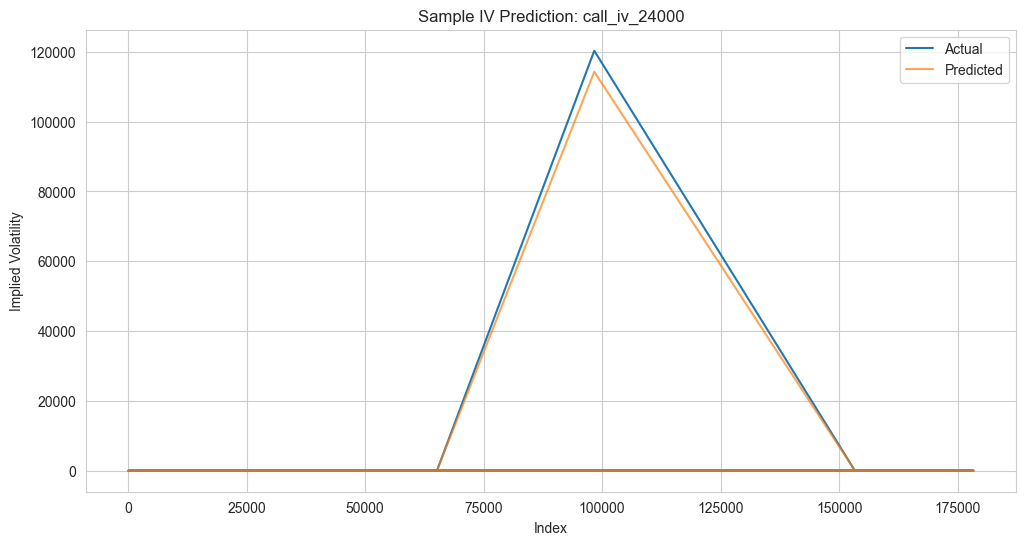

In [8]:
# Apply to validation set
val_pred = predict_iv(val_df)

# Calculate MSE only on originally masked validation points
mse_vals = []
for col in iv_columns:
    if col in val_df.columns and col in val_pred.columns:
        # Focus only on points that were originally missing
        mask = val_df[col].isna() & val_pred[col].notna()
        if mask.any():
            se = (val_df.loc[mask, col] - val_pred.loc[mask, col]) ** 2
            mse_vals.append(se.mean())

validation_mse = np.mean(mse_vals) if mse_vals else 0
print(f"Validation MSE (masked points only): {validation_mse:.12f}")

# Plot sample predictions vs actuals
sample_col = iv_columns[0]
plt.figure(figsize=(12, 6))
plt.plot(val_df[sample_col], label='Actual')
plt.plot(val_pred[sample_col], label='Predicted', alpha=0.7)
plt.title(f'Sample IV Prediction: {sample_col}')
plt.xlabel('Index')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

## 9. Apply to Test Set

In [13]:
# Apply to test set
test_pred = predict_iv(test)

# Verify no missing values
print("Missing values in test predictions:", test_pred[iv_columns].isna().sum().sum())

Missing values in test predictions: 0


## 10. Prepare Submission

In [14]:
# Prepare submission
submission = test_pred[['timestamp'] + iv_columns].copy()
submission.columns = sample_sub.columns

# Verify no missing values
assert submission.isna().sum().sum() == 0, "Missing values detected"
submission.to_csv('submission.csv', index=False)

print("\nFinal Submission Preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Validation MSE: {validation_mse:.12f}") 


Final Submission Preview:
   timestamp  call_iv_24000  call_iv_24100  call_iv_24200  call_iv_24300  \
0          0       0.280939       0.267927       0.257133       0.248545   
1          1       0.271200       0.267992       0.258893       0.251327   
2          2       0.262774       0.251658       0.238608       0.226279   
3          3       0.241888       0.230348       0.220505       0.210733   
4          4       0.235328       0.228326       0.223020       0.214126   

   call_iv_24400  call_iv_24500  call_iv_24600  call_iv_24700  call_iv_24800  \
0       0.242149       0.237496       0.232434       0.225779       0.222997   
1       0.244875       0.239167       0.233548       0.228209       0.226405   
2       0.214869       0.204580       0.194604       0.188052       0.183271   
3       0.198602       0.186190       0.175025       0.166394       0.161561   
4       0.206156       0.199485       0.192603       0.186450       0.181496   

   ...  put_iv_24600  put_iv_24700 

## 11. Visualize Predictions

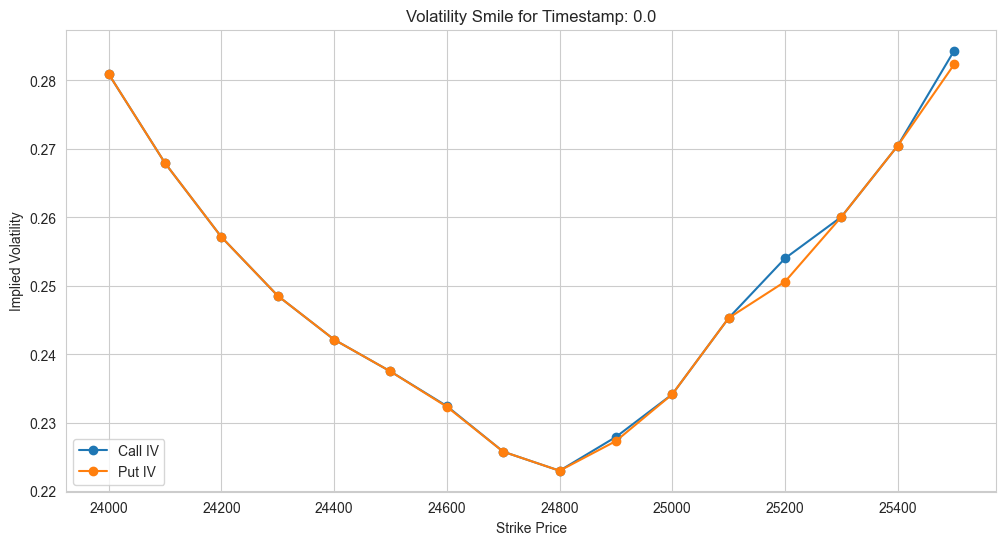

In [15]:
# Plot volatility smile for a sample timestamp
sample_idx = 0
sample_row = test_pred.iloc[sample_idx]

# Extract call and put IVs
call_ivs = []
put_ivs = []
strikes = []

for strike, cols in strike_dict.items():
    if cols['call'] in sample_row and cols['put'] in sample_row:
        try:
            strike_float = float(strike)
            strikes.append(strike_float)
            call_ivs.append(sample_row[cols['call']])
            put_ivs.append(sample_row[cols['put']])
        except:
            continue

# Sort by strike
sorted_idx = np.argsort(strikes)
strikes = np.array(strikes)[sorted_idx]
call_ivs = np.array(call_ivs)[sorted_idx]
put_ivs = np.array(put_ivs)[sorted_idx]

plt.figure(figsize=(12, 6))
plt.plot(strikes, call_ivs, label='Call IV', marker='o')
plt.plot(strikes, put_ivs, label='Put IV', marker='o')
plt.title(f'Volatility Smile for Timestamp: {sample_row["timestamp"]}')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()